# Exploration continue d'une dimension discrète

Alors qu'il est assez simple de visualiser la distribution globale des champs à valeurs numériques, par exemple avec un histogramme, il est plus difficile d'obtenir des représentations globales pour les champs à valeurs textuelles.

Intuitivement, un "yaourt à la myrtille" est plus similaire à un "yaourt à la fraise" qu'un "emmental au lait cru".
Les techniques les plus classiques modélisent les chaînes de caractères comme des sacs de mots, en ajoutant divers pré-traitements pour gérer les flexions et les variations de graphies.
Une technique alternative, un peu plus fine, consiste à représenter les chaînes de caractères comme des sacs de n-grammes de lettres, permettant de calculer une mesure de similarité à valeur continue. 

In [2]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# modifier le chemin vers le fichier CSV si nécessaire
# ici on utilise le fichier filtré dans le notebook précédent
CSV_FILE = '../data/off_subset.csv'

In [4]:
# on charge les types de données qu'on a spécifiés dans le notebook 1
OFF_DTYPE_FILE = '../data/off_dtype.txt'
with open(OFF_DTYPE_FILE) as f:
    off_dtype = eval(f.read())

In [5]:
# TODO charger les données
df = pd.read_csv(CSV_FILE, sep='\t', encoding='utf-8')

/home/mathieu/miniconda3/envs/off-explore/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## dirty-cat

La bibliothèque `dirty_cat` (en développement actif) permet de calculer des mesures de similarité entre valeurs d'une variable catégorielle, afin d'exposer ces similarités aux composants suivants dans un système prédictif (machine learning).
Les manipulations ci-dessous sont largement inspirées de la [documentation de dirty_cat](https://dirty-cat.github.io/stable/auto_examples/01_investigating_dirty_categories.html).

Dirty-cat est normalement déjà installée dans votre environnement conda, mais sinon vous pouvez l'installer en ligne de commande :
```sh
pip install --user dirty_cat
```

Afin de conserver des temps de calcul raisonnables, nous allons sélectionner les 1000 premières fiches de produits laitiers ('categories_tags' contient 'en:dairies') et travailler uniquement sur celles-ci avec `dirty_cat`.
Pour cela, nous pouvons utiliser [`str.contains`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.contains.html).

In [4]:
# TODO
# df_sub = ...

Nous pouvons afficher les noms de produits renseignés dans ces 1000 fiches, avec leur nombre d'occurrences, en utilisant [`value_counts`](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html).

In [3]:
# TODO

Nous pouvons trier les noms de produits avec [`sort_values`](https://pandas.pydata.org/docs/reference/api/pandas.Series.sort_values.html) et n'en garder que les valeurs uniques avec [`unique`](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html).

In [22]:
# TODO
# sorted_values = ...

Nous pouvons maintenant utiliser l'encodeur par similarité [`SimilarityEncoder`](https://dirty-cat.github.io/stable/generated/dirty_cat.SimilarityEncoder.html#dirty_cat.SimilarityEncoder), paramétré pour utiliser la similarité [n-gramme](https://fr.wikipedia.org/wiki/N-gramme).

In [ ]:
from dirty_cat import SimilarityEncoder

similarity_encoder = SimilarityEncoder(similarity='ngram')
transformed_values = similarity_encoder.fit_transform(
    sorted_values.reshape(-1, 1))

De quelle longueur sont les n-grammes que nous utilisons ici?

Quelles sont les dimensions de `transformed_values` ?

Pour mieux comprendre la représentation créée par l'encodeur de similarité, nous pouvons afficher quelques noms de produits sur un graphe en 2 dimensions.
Nous utilisons ici la méthode de réduction de dimensionalité [Multidimensional Scaling](https://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling) .

In [24]:
from sklearn.manifold import MDS

mds = MDS(dissimilarity='precomputed', n_init=10, random_state=42)
two_dim_data = mds.fit_transform(1 - transformed_values)
# les valeurs transformées sont dans l'intervalle [0, 1], donc
# 1-transformed_values produit une matrice de dissimilarités positive
print(two_dim_data.shape)
print(sorted_values.shape)

(881, 2)
(881,)


Nous sélectionnons aléatoirement quelques fiches produits (par exemple `n_points = 5`) qui seront autant de points affichés sur le graphe.
Pour chaque point sélectionné aléatoirement, nous affichons également son ou ses plus proches voisins fournis par un modèle de k plus proches voisins (kNN) dans l'espace transformé produit par l'encodeur de similarités.

In [26]:
n_points = 5
np.random.seed(81)
#
from sklearn.neighbors import NearestNeighbors

random_points = np.random.choice(len(similarity_encoder.categories_[0]),
                                 n_points, replace=False)
nn = NearestNeighbors(n_neighbors=2).fit(transformed_values)
_, indices_ = nn.kneighbors(transformed_values[random_points])
indices = np.unique(indices_.squeeze())

Puis on dessine le graphe en ajoutant les catégories de départ (ici les noms de produits).

In [27]:
sorted_values[indices]

array(['Cantal Entre Deux AOP (30% MG)', 'Cantal entre-deux (29% MG)',
       'Emmental pièce', 'Emmental slices', 'Gouda vieux',
       'Goudse kaas vieux 48+', 'Muesli Yaourt pomme-framboise',
       'Yaourt Noix de Coco Yogosan', 'Yaourt Noix de coco 250g',
       'Yaourt type pomme caramélisée'], dtype=object)

Text(0.5, 1.0, "Représentation Multi-dimensional scaling à partir d'une matrice de similarité 3-gram")

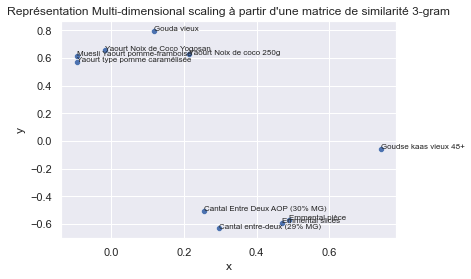

In [28]:
df_mds = pd.DataFrame({'x': two_dim_data[indices, 0],
                       'y': two_dim_data[indices, 1],
                       'product_name': sorted_values[indices]})
ax = sns.scatterplot(x='x', y='y', data=df_mds)
# afficher les noms de produits
for x, y, name_prod in df_mds.itertuples(index=False):
    ax.text(x=x, y=y, s=name_prod,
            fontsize=8)
# titre
ax.set_title(
    "Représentation Multi-dimensional scaling à partir d'une matrice de similarité 3-gram")

### Heatmap de la matrice de similarité

Nous pouvons afficher la matrice de similarité pour ces observations.

<AxesSubplot:>

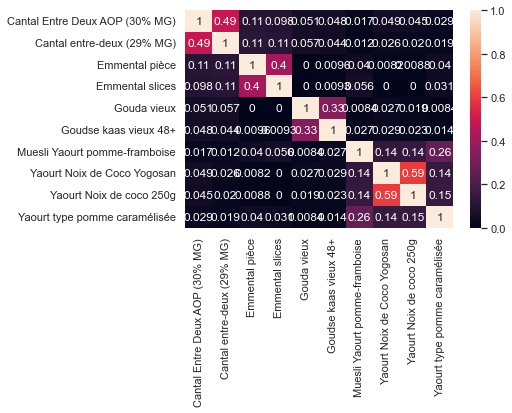

In [29]:
df_trans = pd.DataFrame(transformed_values[indices, :][:, indices],
                        index=sorted_values[indices],
                        columns=sorted_values[indices])
#
sns.heatmap(df_trans, annot=True)